In [16]:
from docxtpl import DocxTemplate
doc = DocxTemplate("작업확인서.docx")
context = {
    'yr_01' : "25",  # 01_yr → yr_01
    'mm_02' : "05",   # 02_mm → mm_02
    'dd_03' : "31",
    'location_04' : "우리집",
    'device_05' : "K7",
    'carno_06' : "3541",
    'hr_07' : "11",
    'min_08' : "30",
    'hr_09' : "12",
    'min_10' : "30",
    'hr_11' : "1",
    'min_12' : "00",
    'work_content_13' : "드라이브",
    'yy_14' : "25",
    'mm_15' : "05",
    'dd_16' : "31",
    'cert_17' : "안용상",  # 중복 키 수정
    'cert_18' : "안용상"   # 고유한 키 사용
}

doc.render(context)
doc.save("generated.docx")


In [18]:
from kivymd.app import MDApp
from kivymd.uix.screen import MDScreen
from kivymd.uix.button import MDRaisedButton
from kivymd.uix.textfield import MDTextField
from kivymd.uix.boxlayout import MDBoxLayout
from kivymd.uix.dialog import MDDialog

from docxtpl import DocxTemplate
import os

class WorkFormApp(MDApp):
    def build(self):
        self.screen = MDScreen()

        self.inputs = {}
        field_keys = [
            'yr_01', 'mm_02', 'dd_03', 'location_04', 'device_05', 'carno_06',
            'hr_07', 'min_08', 'hr_09', 'min_10', 'hr_11', 'min_12',
            'work_content_13', 'yy_14', 'mm_15', 'dd_16', 'cert_17', 'cert_18'
        ]

        layout = MDBoxLayout(orientation='vertical', padding=10, spacing=10)
        for key in field_keys:
            tf = MDTextField(hint_text=key, mode='rectangle')
            self.inputs[key] = tf
            layout.add_widget(tf)

        btn = MDRaisedButton(text="Generate DOCX", on_release=self.generate_docx)
        layout.add_widget(btn)

        self.screen.add_widget(layout)
        return self.screen

    def generate_docx(self, instance):
        context = {k: v.text for k, v in self.inputs.items()}
        try:
            doc = DocxTemplate("작업확인서.docx")
            doc.render(context)

            # Android 경로 (Download 폴더)
            save_path = "/sdcard/Download/generated.docx"
            doc.save(save_path)

            MDDialog(title="성공", text=f"저장 완료: {save_path}").open()
        except Exception as e:
            MDDialog(title="오류 발생", text=str(e)).open()

if __name__ == "__main__":
    WorkFormApp().run()

[WARNING] [Config      ] Older configuration version detected (0 instead of 27)
[WARNING] [Config      ] Upgrading configuration in progress.
[DEBUG  ] [Config      ] Upgrading from 0 to 1
[INFO   ] [Logger      ] Record log in C:\Users\qhfkd\.kivy\logs\kivy_25-05-31_0.txt
[ERROR  ] [Core        ] option --f not a unique prefix


Kivy Usage: ipykernel_launcher.py [KIVY OPTION...] [-- PROGRAM OPTIONS]::

            Options placed after a '-- ' separator, will not be touched by kivy,
            and instead passed to your program.

            Set KIVY_NO_ARGS=1 in your environment or before you import Kivy to
            disable Kivy's argument parser.

        -h, --help
            Prints this help message.
        -d, --debug
            Shows debug log.
        -a, --auto-fullscreen
            Force 'auto' fullscreen mode (no resolution change).
            Uses your display's resolution. This is most likely what you want.
        -c, --config section:key[:value]
            Set a custom [section] key=value in the configuration object.
        -f, --fullscreen
            Force running in fullscreen mode.
        -k, --fake-fullscreen
            Force 'fake' fullscreen mode (no window border/decoration).
            Uses the resolution specified by width and height in your config.
        -w, --windowed
 

AttributeError: 'tuple' object has no attribute 'tb_frame'

In [6]:
import cv2
import numpy as np
import os

def extract_row_heights(image_path):
    """
    작업확인서 테이블의 각 행 높이를 위에서부터 추출 (에러 처리 포함)
    """
    # 파일 존재 여부 확인
    if not os.path.exists(image_path):
        print(f"❌ 파일이 존재하지 않습니다: {image_path}")
        return None
    
    # 이미지 로드 및 None 체크
    image = cv2.imread(image_path)
    if image is None:
        print(f"❌ 이미지를 로드할 수 없습니다: {image_path}")
        print("지원되는 형식: .jpg, .jpeg, .png, .bmp, .tiff")
        return None
    
    print(f"✅ 이미지 로드 성공: {image.shape}")
    
    # 이미지 전처리
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # 가우시안 블러 및 이진화
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    # 수평선 검출을 위한 커널 생성
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 1))
    horizontal_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=1)
    
    # 수평선의 y좌표 추출
    horizontal_coords = []
    height, width = horizontal_lines.shape
    
    for y in range(height):
        row_pixels = horizontal_lines[y, :]
        if np.sum(row_pixels) > width * 0.3 * 255:
            horizontal_coords.append(y)
    
    # 연속된 좌표들을 그룹화
    line_centers = []
    if horizontal_coords:
        current_group = [horizontal_coords[0]]
        
        for i in range(1, len(horizontal_coords)):
            if horizontal_coords[i] - horizontal_coords[i-1] <= 3:
                current_group.append(horizontal_coords[i])
            else:
                center = int(np.mean(current_group))
                line_centers.append(center)
                current_group = [horizontal_coords[i]]
        
        if current_group:
            center = int(np.mean(current_group))
            line_centers.append(center)
    
    # 각 행의 높이 계산
    row_heights = []
    if len(line_centers) >= 2:
        for i in range(len(line_centers) - 1):
            height = line_centers[i + 1] - line_centers[i]
            row_heights.append(height)
    
    return {
        'line_positions': line_centers,
        'row_heights': row_heights,
        'total_rows': len(row_heights)
    }

# 사용 예시
# 현재 디렉토리의 파일 목록 출력
print("📁 현재 디렉토리 파일 목록:")
for file in os.listdir('.'):
    if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
        print(f"  - {file}")

# 여러 가능한 파일명 시도
possible_names = [
    "작업확인서.jpg",
    "작업확인서.png", 
    "image.jpg",
    "work_confirmation.jpg"
]

image_path = None
for name in possible_names:
    if os.path.exists(name):
        image_path = name
        break

if image_path is None:
    print("❌ 작업확인서 이미지 파일을 찾을 수 없습니다.")
    print("다음 중 하나로 파일명을 변경하거나 올바른 경로를 지정하세요:")
    for name in possible_names:
        print(f"  - {name}")
else:
    print(f"🔍 분석할 이미지: {image_path}")
    result = extract_row_heights(image_path)
    
    if result:
        print("\n=== 작업확인서 테이블 분석 결과 ===")
        print(f"검출된 수평선 위치: {result['line_positions']}")
        print(f"각 행의 높이: {result['row_heights']}")
        print(f"총 행 개수: {result['total_rows']}")


📁 현재 디렉토리 파일 목록:
  - 작업확인서.jpg
🔍 분석할 이미지: 작업확인서.jpg
❌ 이미지를 로드할 수 없습니다: 작업확인서.jpg
지원되는 형식: .jpg, .jpeg, .png, .bmp, .tiff


In [13]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# matplotlib으로 이미지 읽기
img_rgb = plt.imread("작업확인서.jpg")

# OpenCV 형식으로 변환 (BGR)
if img_rgb.dtype == np.float32 or img_rgb.dtype == np.float64:
    img_rgb = (img_rgb * 255).astype(np.uint8)

img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
print(f"이미지 로드 성공: {img_bgr.shape}")
# 그레이스케일 변환
gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

# 이진화
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# 수평선 검출을 위한 커널 생성 (이전 에러 수정)
kernel_width = gray.shape[1] // 10  # 이미지 너비의 1/10
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_width, 1))

# 형태학적 연산으로 수평선 추출
horizontal_lines = cv2.erode(thresh, horizontal_kernel, iterations=3)
horizontal_lines = cv2.dilate(horizontal_lines, horizontal_kernel, iterations=3)

# 윤곽선 검출
contours, _ = cv2.findContours(horizontal_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 수평선 y좌표 추출
line_y_positions = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    if w > gray.shape[1] * 0.5:  # 이미지 너비의 50% 이상인 선만 선택
        line_y_positions.append(y + h // 2)

# y좌표 기준 정렬
line_y_positions.sort()

# 각 행의 높이 계산
row_heights = []
for i in range(len(line_y_positions) - 1):
    height = line_y_positions[i + 1] - line_y_positions[i]
    row_heights.append(height)

print("=== 작업확인서 테이블 분석 결과 ===")
print(f"검출된 수평선 위치: {line_y_positions}")
print(f"각 행의 높이: {row_heights}")
print(f"총 행 개수: {len(row_heights)}")

# 행별 세부 정보
for i, height in enumerate(row_heights):
    print(f"행 {i+1}: {height}px")


이미지 로드 성공: (1504, 1040, 3)
=== 작업확인서 테이블 분석 결과 ===
검출된 수평선 위치: [63, 1078, 1163, 1246, 1425, 1503]
각 행의 높이: [1015, 85, 83, 179, 78]
총 행 개수: 5
행 1: 1015px
행 2: 85px
행 3: 83px
행 4: 179px
행 5: 78px


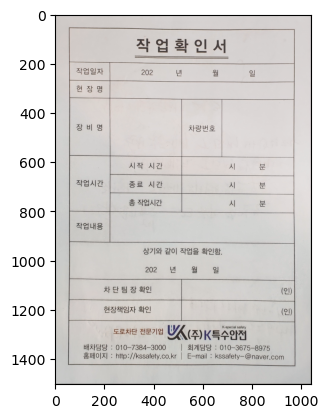

In [14]:
plt.imshow(img_bgr)

In [7]:
import os 
os.listdir()

['generated.docx',
 'test.ipynb',
 '~$작업확인서.docx',
 '업체명.docx',
 '작업확인서.docx',
 '작업확인서.jpg']